In [32]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import spacy
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
%matplotlib inline

In [33]:
df = pd.read_csv('BBC.csv')
df = df.drop(columns="tags")
df = df.drop(columns="Unnamed: 0")

In [34]:
df.head()

,description
0,chelsea sack mutu chelsea have sacked adrian ...
1,record fails to lift lacklustre meet yelena i...
2,edu describes tunnel fracas arsenals edu has ...
3,ogara revels in ireland victory ireland flyha...
4,unclear future for striker baros liverpool fo...


In [35]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.description.apply(lambda x: clean_data(x)))

In [36]:
df_clean.head()

,description
0,chelsea sack mutu chelsea sacked adrian mutu f...
1,record fails lift lacklustre meet yelena isinb...
2,edu describes tunnel fracas arsenals edu lifte...
3,ogara revels ireland victory ireland flyhalf r...
4,unclear future striker baros liverpool forward...


In [38]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['description']), axis=1)

In [39]:
df_clean.head()

,description,text_lemmatize
0,chelsea sack mutu chelsea sacked adrian mutu f...,chelsea sack mutu chelsea sack adrian mutu fai...
1,record fails lift lacklustre meet yelena isinb...,record fail lift lacklustre meet yelena isinba...
2,edu describes tunnel fracas arsenals edu lifte...,edu describe tunnel fracas arsenal edu lift li...
3,ogara revels ireland victory ireland flyhalf r...,ogara revel ireland victory ireland flyhalf ro...
4,unclear future striker baros liverpool forward...,unclear future striker baros liverpool forward...


In [40]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [41]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

26845

In [42]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'would', 'year', 'make', 'people', 'also', 'new', 'one', 'use']

In [43]:
#Using inbuilt gensim Model
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)

In [44]:
#Preparing the model vocabulary
w2v_model.build_vocab(sentences)

In [45]:
#Training the model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/Users/aknursh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(1139438, 2660135)

In [46]:
# Memory opitmization by usage of init_sims()
w2v_model.init_sims(replace=True)

In [47]:
#Test: most similiar words for 'growth'
w2v_model.wv.most_similar(positive=['growth'])

[('economy', 0.9449494481086731),
 ('rise', 0.9264495372772217),
 ('rate', 0.9236757755279541),
 ('figure', 0.9120374321937561),
 ('low', 0.9056905508041382),
 ('continue', 0.9034478664398193),
 ('predict', 0.89988112449646),
 ('price', 0.899746298789978),
 ('likely', 0.8909440040588379),
 ('grow', 0.8907052278518677)]

In [48]:
#Test: most similiar words for 'statement'
w2v_model.wv.most_similar(positive=['statement'])

[('spokesman', 0.945975124835968),
 ('chairman', 0.9318596720695496),
 ('president', 0.8938816785812378),
 ('police', 0.892228364944458),
 ('comment', 0.8895753026008606),
 ('secretary', 0.8740367889404297),
 ('official', 0.8713991641998291),
 ('political', 0.8669283390045166),
 ('deny', 0.8657426834106445),
 ('question', 0.8651540875434875)]

In [49]:
# Similarity of two words
w2v_model.wv.similarity('growth', 'economy')

0.9449494

In [55]:
def tsne_plot(model, wordSearch):
    labels = []
    tokens = []
    
    tokens.append(model[wordSearch])
    labels.append(wordSearch)

    for word, value in model.wv.most_similar(positive=[wordSearch]):
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10))
    plt.scatter(x[0],y[0], c='#ff0000')
    plt.annotate(labels[0],
                     xy=(x[0], y[0]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    for i in range(1, len(x)):
        plt.scatter(x[i],y[i], c='#000000')
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [56]:
w2v_model.wv.vocab

{'fail': <gensim.models.keyedvectors.Vocab at 0x1a216e2cc0>,
 'drug': <gensim.models.keyedvectors.Vocab at 0x1a216e2c18>,
 'test': <gensim.models.keyedvectors.Vocab at 0x1a216e2198>,
 'yearold': <gensim.models.keyedvectors.Vocab at 0x1a216e24e0>,
 'ban': <gensim.models.keyedvectors.Vocab at 0x1a216e2390>,
 'later': <gensim.models.keyedvectors.Vocab at 0x1a216e2b70>,
 'deny': <gensim.models.keyedvectors.Vocab at 0x1a216e2978>,
 'decide': <gensim.models.keyedvectors.Vocab at 0x1a216e2ac8>,
 'write': <gensim.models.keyedvectors.Vocab at 0x1a216e28d0>,
 'possible': <gensim.models.keyedvectors.Vocab at 0x1a216e2a58>,
 'last': <gensim.models.keyedvectors.Vocab at 0x1a216e2828>,
 'season': <gensim.models.keyedvectors.Vocab at 0x1a216e29b0>,
 'may': <gensim.models.keyedvectors.Vocab at 0x1a216e27b8>,
 'face': <gensim.models.keyedvectors.Vocab at 0x1a216e2908>,
 'statement': <gensim.models.keyedvectors.Vocab at 0x1a216e2748>,
 'decision': <gensim.models.keyedvectors.Vocab at 0x1a216e2860>,
 'wa

/Users/aknursh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/Users/aknursh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


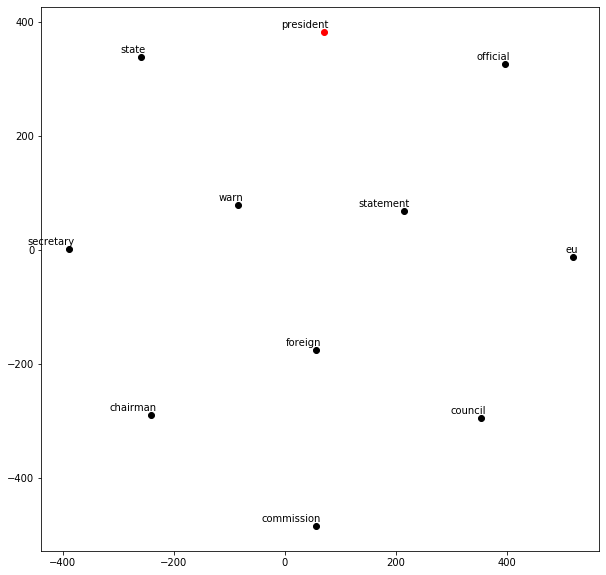

In [57]:
tsne_plot(w2v_model, 'president')

/Users/aknursh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/Users/aknursh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


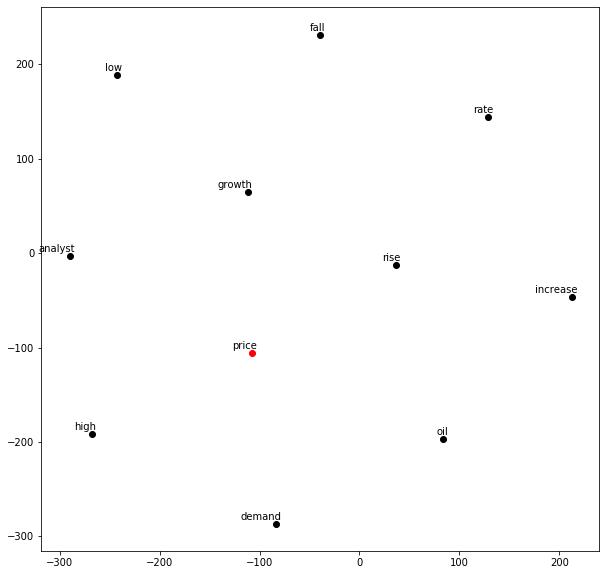

In [58]:
tsne_plot(w2v_model, 'price')

/Users/aknursh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/Users/aknursh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


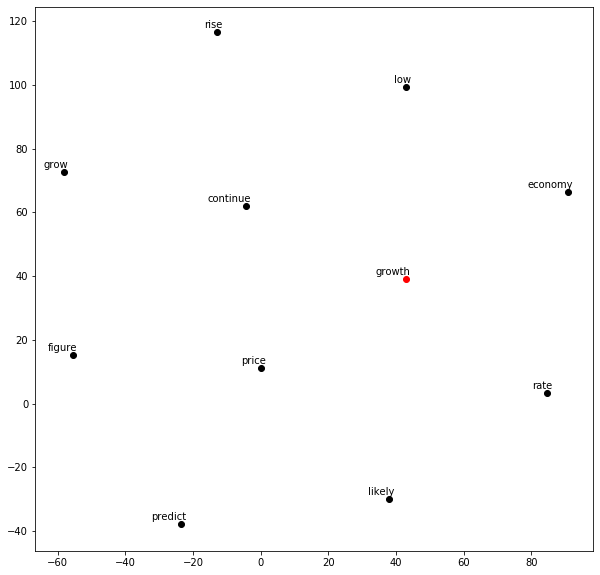

In [59]:
tsne_plot(w2v_model, 'growth')